<a href="https://colab.research.google.com/github/Md-Shabab-Mehebub/AlphaFold_3_Ranking_Score_Extraction_and_Visualization/blob/main/AlphaFold3_ranking_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Purpose
This notebook is designed to extract and visualize ranking scores (0.8 × ipTM + 0.2 × pTM + 0.5 × disorder − 100 × has_clash) from AlphaFold 3 biomolecular structure prediction results. It processes batch JSON summary files from all subfolders in your specified Google Drive path, extracts the 'ranking_score', and saves the collected data into a CSV file. Finally, it generates a scatter plot to visualize the distribution of these ranking scores. The scatter plot is inspired by the paper of [Homma et al. (2023)](https://doi.org/10.1038/s41467-023-41721-9).

The entire notebook is written with the help of Google Gemini.

In [ ]:
from google.colab import drive
import os
import json
import glob
import pandas as pd

# Function to extract pair name from filename
def extract_pair_name(filename):
    """Extracts the pair name from a given filename based on the specified format."""
    file_basename = os.path.basename(filename)
    if file_basename.startswith('fold_'):
        parts = file_basename.split('_')
        if len(parts) > 2:
            try:
                # Find the index of 'summary' or 'full_data' to determine the end of the pair name
                end_index = parts.index('summary') if 'summary' in parts else (parts.index('full_data') if 'full_data' in parts else -1)
                if end_index > 1:
                    return '_'.join(parts[1:end_index])
            except ValueError:
                pass # 'summary' or 'full_data' not found in parts
    return 'Not available'

# Function to process a single JSON file
def process_json_file(filepath):
    """Processes a single JSON file, extracts ranking data and pair name."""
    try:
        with open(filepath, 'r') as infile:
            data = json.load(infile)
            ranking_data_list = []

            if isinstance(data, dict) and 'ranking_score' in data:
                data['source_filename'] = filepath
                data['pair_name'] = extract_pair_name(filepath)
                ranking_data_list.append(data)
            elif isinstance(data, list):
                for item in data:
                    if isinstance(item, dict) and 'ranking_score' in item:
                        item['source_filename'] = filepath
                        item['pair_name'] = extract_pair_name(filepath)
                        ranking_data_list.append(item)
            else:
                 print(f"Skipping file {filepath}: unexpected data structure or missing 'ranking_score'.")
            return ranking_data_list
    except json.JSONDecodeError:
        print(f"Skipping file {filepath}: Invalid JSON format.")
    except Exception as e:
        print(f"An error occurred while processing {filepath}: {e}")
    return []

# Mount Google Drive
drive.mount('/content/drive')

#@title Specify Input and Output Paths
#@markdown Enter the path to the main folder in your Google Drive containing the results from AlphaFold 3:
main_google_drive_folder_path = "/content/drive/My Drive/AF3_analysis/results" #@param {type:"string"}
#@markdown Enter the desired output directory for the CSV file:
output_directory = "/content/drive/My Drive/AF3_analysis/results" #@param {type:"string"}


# Check if the main folder exists
if not os.path.isdir(main_google_drive_folder_path):
    print(f"Error: The main folder '{main_google_drive_folder_path}' was not found in your Google Drive.")
    print("Please check the path and try again.")
else:
    print(f"Accessing main directory: {main_google_drive_folder_path}")

    # List all subfolders in the main directory
    subfolders = [f.path for f in os.scandir(main_google_drive_folder_path) if f.is_dir()]
    print(f"\nFound {len(subfolders)} subfolders:")
    for subfolder in subfolders:
        print(subfolder)

    all_ranking_data = []

    # Iterate through each subfolder
    for subfolder in subfolders:
        print(f"\nProcessing subfolder: {subfolder}")
        # Get all 'summary_confidences' json files in the current subfolder
        summary_json_files = glob.glob(os.path.join(subfolder, '*summary_confidences*.json'))
        print("Available 'summary_confidences' JSON files in subfolder:", [os.path.basename(f) for f in summary_json_files])

        # Process each summary json file
        for json_file in summary_json_files:
            all_ranking_data.extend(process_json_file(json_file))


    # Debugging print statements
    print(f"\nNumber of data entries collected: {len(all_ranking_data)}")

    if all_ranking_data:
        # Convert the list of dictionaries to a pandas DataFrame
        df_all_rankings = pd.DataFrame(all_ranking_data)

        # Reorder columns to have 'pair_name' as the first column
        if 'pair_name' in df_all_rankings.columns:
            cols = ['pair_name'] + [col for col in df_all_rankings.columns if col != 'pair_name']
            df_all_rankings = df_all_rankings[cols]

        # Define a filename for the CSV output
        output_filename_all = 'alphafold3_ranking_data.csv'
        output_filepath = os.path.join(output_directory, output_filename_all)

        try:
            # Ensure the output directory exists
            os.makedirs(output_directory, exist_ok=True)
            # Save the DataFrame to a CSV file
            df_all_rankings.to_csv(output_filepath, index=False)
            print(f"\nRanking data from all suitable JSON files in subfolders successfully saved to {output_filepath}")
        except Exception as e:
            print(f"\nError saving CSV file to {output_filepath}: {e}")

        # Display the first few rows of the DataFrame with the desired columns
        display(df_all_rankings[['pair_name', 'source_filename', 'ranking_score']].head())
    else:
        print("\nNo ranking data with 'ranking_score' found in the suitable JSON files across all subfolders.")

Successfully loaded the 'ranking_score' column from your file.


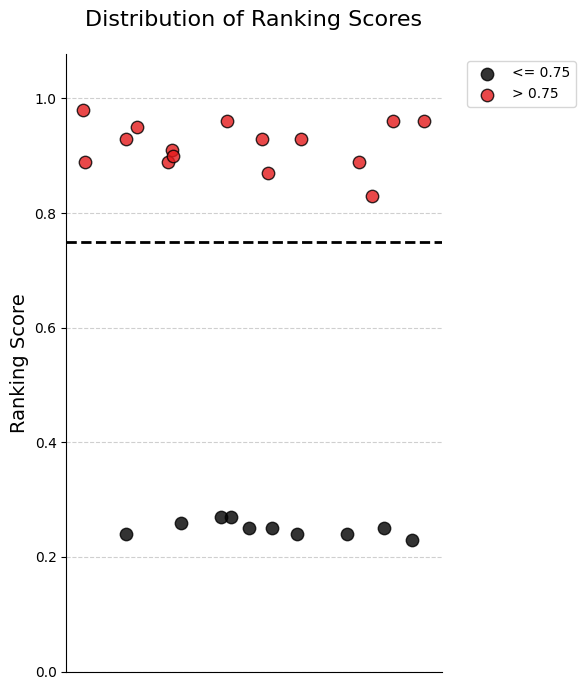

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#@title Plot Ranking Scores
#@markdown Specify the path to the CSV file and the threshold for coloring points.

#@markdown Enter the path to the CSV file containing the ranking data:
file_path = '/content/drive/My Drive/AF3_analysis/results/alphafold3_ranking_data.csv' #@param {type:"string"}

#@markdown Enter the threshold for coloring points:
threshold = 0.75 #@param {type:"number"}

# Load the 'ranking_score' column from your CSV
try:
    # Use 'usecols' to efficiently load only the required column.
    df = pd.read_csv(file_path, usecols=['ranking_score'])
    print("Successfully loaded the 'ranking_score' column from your file.")

    # Create the Plot

    # Separate the data into two groups for coloring.
    df_above = df[df['ranking_score'] > threshold]
    df_below = df[df['ranking_score'] <= threshold]

    # Create the figure and axes for the plot.
    fig, ax = plt.subplots(figsize=(6, 7))

    # Create random horizontal spread ('jitter') for each group.
    jitter_below = np.random.uniform(-0.05, 0.05, size=len(df_below))
    jitter_above = np.random.uniform(-0.05, 0.05, size=len(df_above))

    # Plot the points at or below the threshold in black.
    ax.scatter(
        jitter_below, df_below['ranking_score'],
        alpha=0.8, s=80, edgecolor='k', linewidth=1,
        zorder=5, color='black', label=f'<= {threshold}'
    )
    # Plot the points above the threshold in red.
    ax.scatter(
        jitter_above, df_above['ranking_score'],
        alpha=0.8, s=80, edgecolor='k', linewidth=1,
        zorder=5, color='#e41a1c', label=f'> {threshold}'
    )

    # --- 4. Customize the Plot's Appearance ---
    # Add the threshold line.
    ax.axhline(y=threshold, color='k', linestyle='--', linewidth=2)

    # Set labels, limits, and title.
    ax.set_ylabel('Ranking Score', fontsize=14) # Corrected label
    ax.set_ylim(0, max(1.05, df['ranking_score'].max() * 1.1)) # Corrected column name
    ax.set_title('Distribution of Ranking Scores', fontsize=16, pad=20)

    # Clean up the axes and add a grid and legend.
    ax.set_xticks([]) # Hide x-axis ticks.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    # Move the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


    # Display the final plot.
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file was not found at the path: {file_path}")
    print("Please make sure the file path is correct and the file exists in your Google Drive.")
except ValueError as e:
    print(f"Error reading the CSV file: {e}")
    print("Please ensure your CSV file contains a column named exactly 'ranking_score'.")